# Unsupervised surgery pipeline with interpetable autoencoder EXPIMAP

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown

Global seed set to 0


In [4]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download reference and do preprocessing

In [4]:
url = 'https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0'
output = 'pbmc_tutorial.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Rnm-XKEqPLdOq3lpa3ka2aV4bOXVCLP0
To: /home/mo/projects/scarches/notebooks/pbmc_tutorial.h5ad
100%|██████████| 231M/231M [00:02<00:00, 106MB/s]  


'pbmc_tutorial.h5ad'

In [5]:
adata = sc.read('pbmc_tutorial.h5ad')

`.X` should contain raw counts.

In [6]:
adata.X = adata.layers["counts"].copy()

Read Reactome annotations into the reference dataset, the binary matrix of annotation is in `adata.varm['I']`.

In [7]:
url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c
To: /home/mo/projects/scarches/notebooks/reactome.gmt
100%|██████████| 331k/331k [00:00<00:00, 8.35MB/s]


'reactome.gmt'

In [7]:
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)

Remove all genes which are not present in the Reactome annotations.

In [8]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

For a better model performance it is necessary to select HVGs. We are doing this by applying the `scanpy.pp` function `highly_variable_genes()`. The `n_top_genes` is set to 2000 here. Howeever, if you more complicated datasets you might have to increase number of genes to capture more diversity in the data.

In [9]:
sc.pp.normalize_total(adata)

In [10]:
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

Filter out all annotations which has the number of genes lower than 12.

In [12]:
select_terms = adata.varm['I'].sum(0)>12

In [13]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [14]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

Filter out unannotated genes again.

In [15]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

Put count back to `adata.X`.

In [16]:
adata.X = adata.layers["counts"].copy()

### Create EXPIMAP model and train it on reference dataset

In [17]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  282 0 0 4 1972
	with hard mask.
Last Decoder layer: softmax


Set the `alpha` hyperparameter, it regulates the strength of group lasso regularization of annotations (terms). Higher value means that higher number of latent variables corresponding to annotations will be deactivated during training depending on their contribution to the reconstruction loss.

In [18]:
ALPHA = 0.7

In [19]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Init the group lasso proximal operator for the main terms.
 |████████------------| 41.8%  - epoch_loss: 875.0875513335 - epoch_recon_loss: 849.8969689248 - epoch_kl_loss: 50.3811637679 - val_loss: 938.5590139536 - val_recon_loss: 912.9722806490 - val_kl_loss: 51.17346543531427418
ADJUSTED LR
 |█████████-----------| 46.0%  - epoch_loss: 867.2534920638 - epoch_recon_loss: 842.2286955321 - epoch_kl_loss: 50.0495922638 - val_loss: 939.3953810472 - val_recon_loss: 913.6503906250 - val_kl_loss: 51.4899893541
ADJUSTED LR
 |██████████----------| 50.5%  - epoch_loss: 868.1691942506 - epoch_recon_loss: 843.1531918455 - epoch_kl_loss: 50.0320032611 - val_loss: 937.6233802209 - val_recon_loss: 911.8207420936 - val_kl_loss: 51.6052835905
ADJUSTED LR
 |████████████--------| 60.2%  - epoch_loss: 874.0884924476 - epoch_recon_loss: 848.9184943453 - epoch_kl_loss: 50.3399958715 - val_loss: 938.2763272799 - val_recon_loss: 912.5495535044 - val_kl_loss: 51.4535569411
ADJUSTED LR
 |████████████--------| 63

In [20]:
MEAN = False

Plot the latent space of the reference.

In [21]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [22]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [23]:
sc.tl.umap(adata)

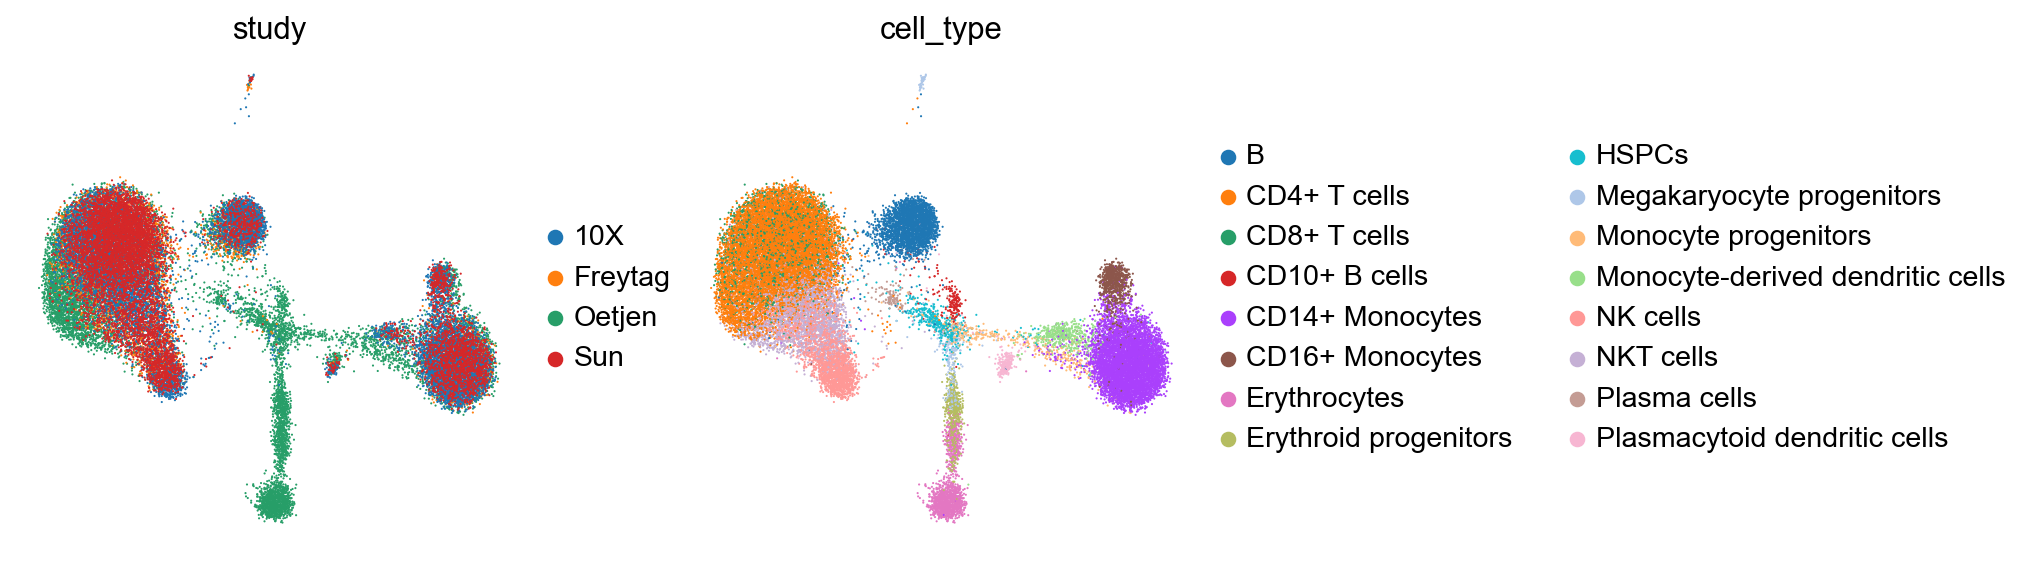

In [24]:
sc.pl.umap(adata, color=['study', 'cell_type'], frameon=False)

Save the reference model

In [24]:
intr_cvae.save('ref_kang_tutorial')

### Download query data to perfrom reference mapping

In [67]:
url = 'https://drive.google.com/uc?id=1t3oMuUfueUz_caLm5jmaEYjBxVNSsfxG'
output = 'kang_tutorial.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1t3oMuUfueUz_caLm5jmaEYjBxVNSsfxG
To: /home/mo/projects/scarches/notebooks/kang_tutorial.h5ad
100%|██████████| 26.8M/26.8M [00:00<00:00, 85.2MB/s]


'kang_tutorial.h5ad'

In [25]:
kang = sc.read('kang_tutorial.h5ad')[:, adata.var_names].copy()

In [26]:
kang.obs['study'] = 'Kang'

In [27]:
kang.uns['terms'] = adata.uns['terms']

Add 5 unconstrained nodes, also use HSIC regularization for them.

In [28]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(kang, intr_cvae,
                                                 unfreeze_ext=True,
                                                 new_n_ext=5,
                                                 use_hsic=True,
                                                 hsic_one_vs_all=True
                                                )


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
	Expanded Mean/Var Layer in/out: 256 5
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  282 0 5 5 1972
	with hard mask.
Last Decoder layer: softmax


In [29]:
q_intr_cvae.train(n_epochs=100, alpha_epoch_anneal=50, weight_decay=0.,
                  alpha_kl=0.2, seed=2020, use_early_stopping=True)

 |████████████████████| 100.0%  - val_hsic_loss: 0.3016676767 - val_loss: 508.0970569957 - val_recon_loss: 494.3710271662 - val_kl_loss: 67.1218261719
Saving best state of network...
Best State was in Epoch 98


Save your model.

In [30]:
q_intr_cvae.save('query_kang_tutorial')

Plot the latent space of the query.

In [30]:
kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN, only_active=True)

In [31]:
sc.pp.neighbors(kang, use_rep='X_cvae')

In [32]:
sc.tl.umap(kang)

... storing 'study' as categorical


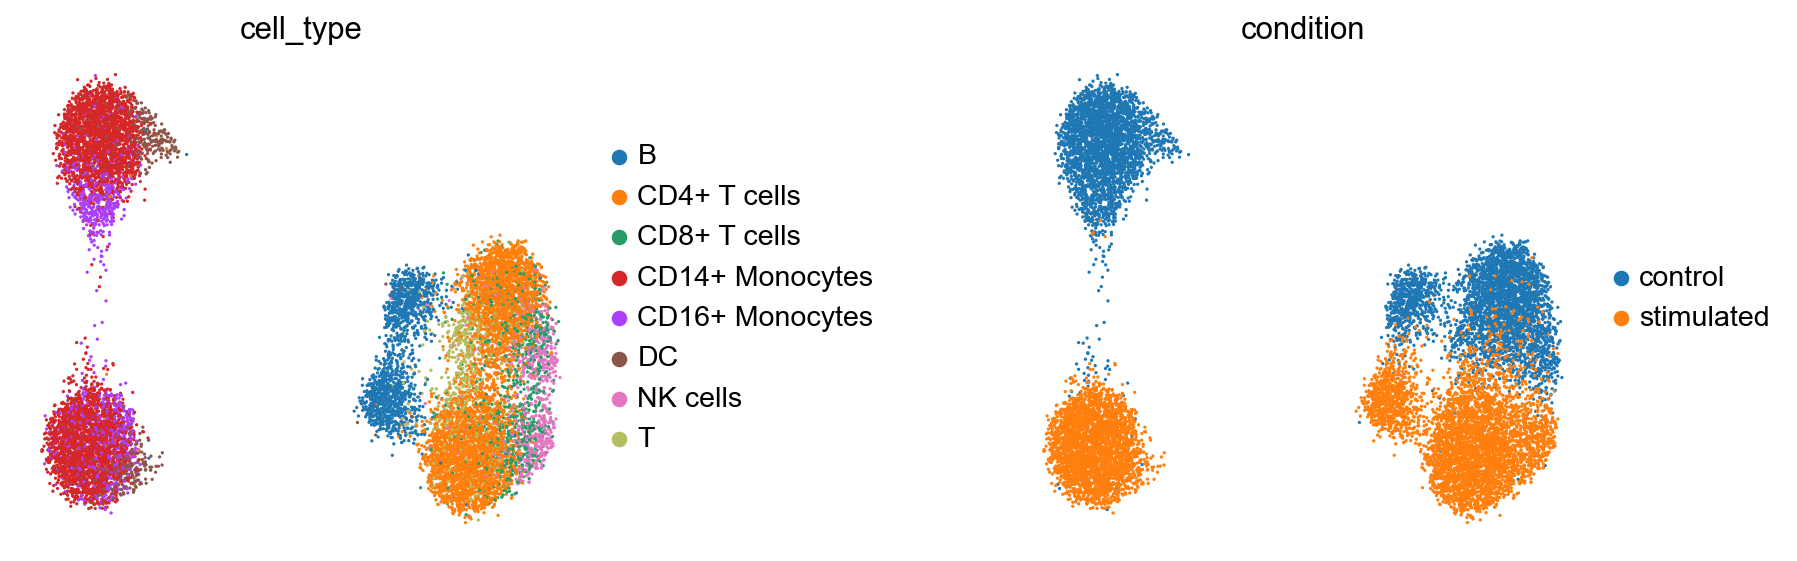

In [33]:
sc.pl.umap(kang, color=['cell_type', 'condition'], frameon=False, wspace=0.6)

### Get latent representation of reference + query dataset

In [34]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join', uns_merge='same')

In [35]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'], mean=MEAN, only_active=True)

In [36]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [37]:
kang_pbmc.obs['condition_joint'] = kang_pbmc.obs.condition.astype(str)
kang_pbmc.obs['condition_joint'][kang_pbmc.obs['condition_joint'].astype(str)=='nan']='control'

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'cell_type' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'condition_joint' as categorical


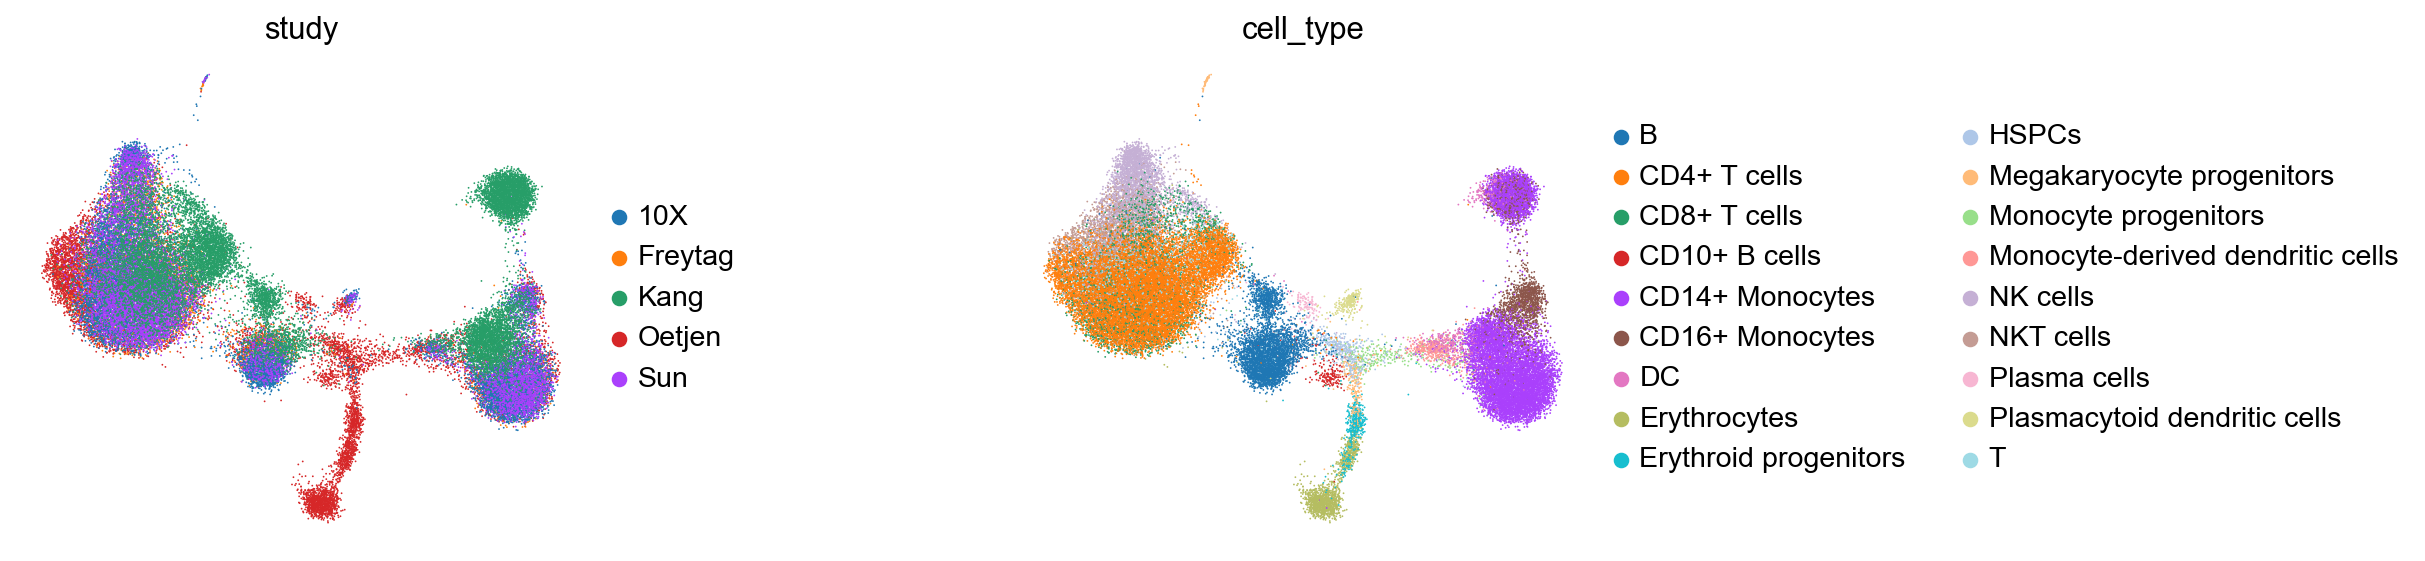

In [38]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type'], frameon=False, wspace=0.6)

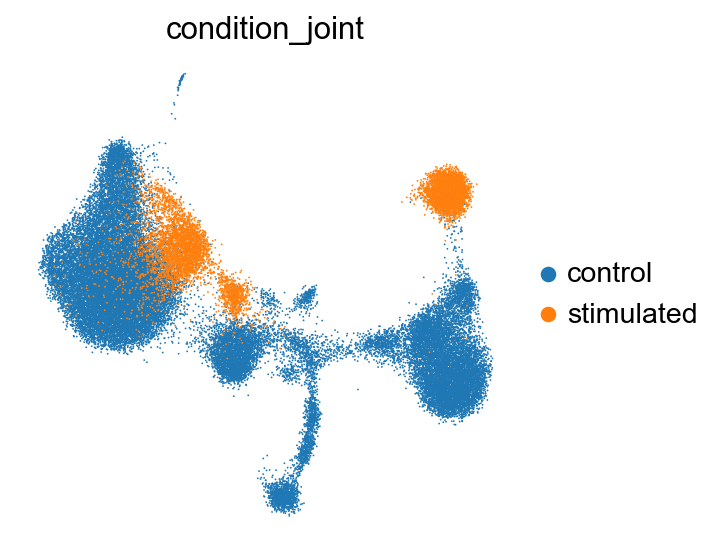

In [39]:
sc.pl.umap(kang_pbmc, color='condition_joint', frameon=False, wspace=0.6)

This adds extension nodes' names to `kang_pbmc.uns['terms']`.

In [40]:
q_intr_cvae.update_terms(adata=kang_pbmc)

Calculate directions of upregulation for each latent score and put them to `kang_pbmc.uns['directions']`.

In [41]:
q_intr_cvae.latent_directions(adata=kang_pbmc)

Do gene set enrichment test for condition in reference + query.

In [42]:
q_intr_cvae.latent_enrich(groups='condition_joint', comparison='control', use_directions=True, adata=kang_pbmc)

Plot absolute bayes factors. 'unconstrained_' are the names for the unconstrained extension nodes.

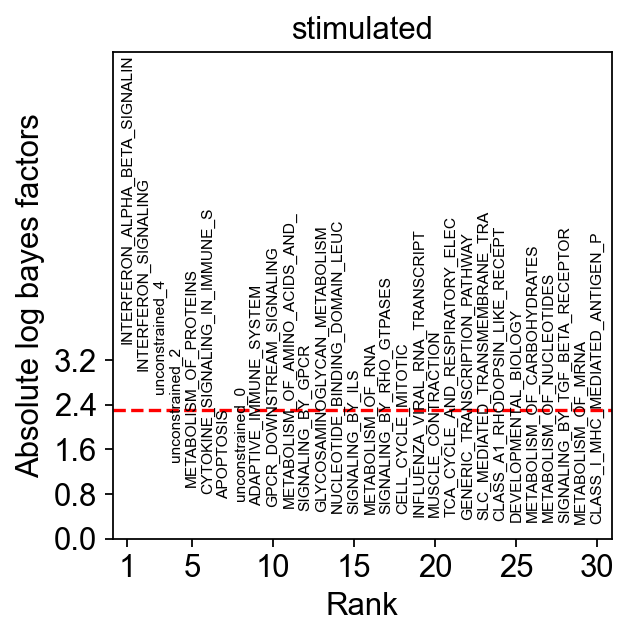

In [44]:
fig = sca.plotting.plot_abs_bfs(kang_pbmc, yt_step=0.8, scale_y=2.5, fontsize=7)

Do gene set enrichment test for cell types in reference + query control.

In [66]:
kang_pbmc_control = kang_pbmc[kang_pbmc.obs['condition_joint']=='control'].copy()

q_intr_cvae.latent_enrich(groups='cell_type', use_directions=True, adata=kang_pbmc_control, n_sample=10000)

In [ ]:
fig = sca.plotting.plot_abs_bfs(kang_pbmc_control, n_cols=3, scale_y=2.6, yt_step=0.6)

In [68]:
fig.set_size_inches(16, 34)

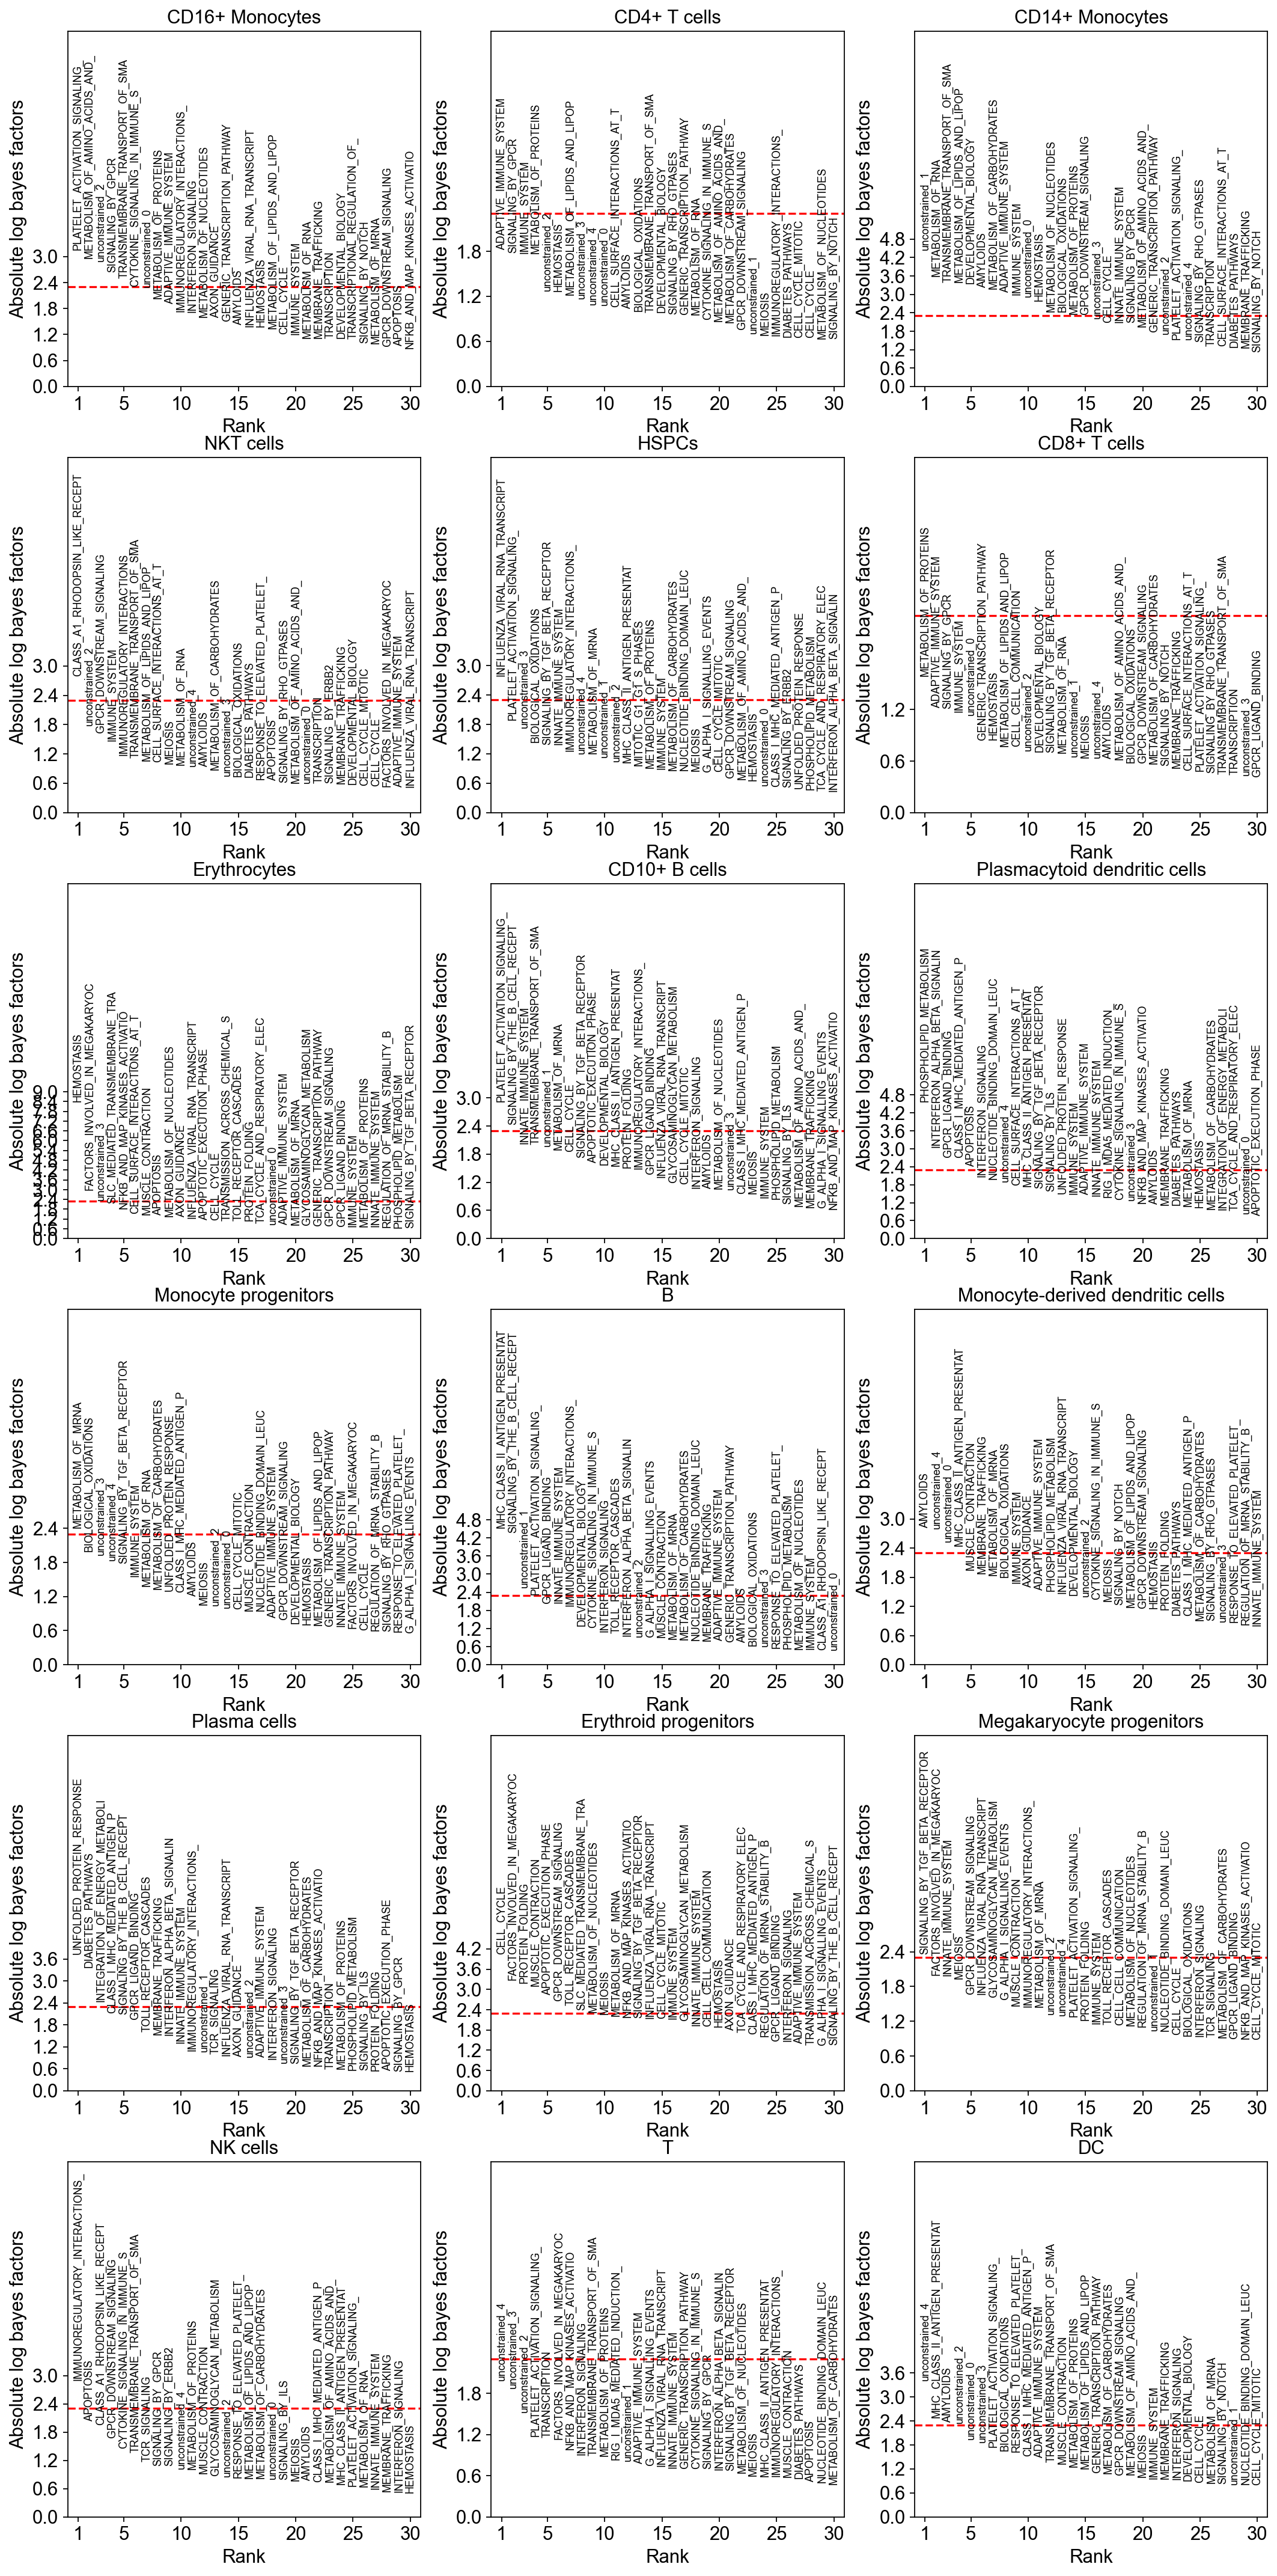

In [69]:
fig

Plot the latent variables for query + reference corresponding to the annotations 'INTERFERON_SIGNALING', 'SIGNALING_BY_THE_B_CELL_RECEPTOR', 'INTERFERON_ALPHA_BETA_SIGNALING' and the extension nodes.

In [52]:
terms = kang_pbmc.uns['terms']
select_terms = ['INTERFERON_SIGNALING', 'INTERFERON_ALPHA_BETA_SIGNALIN', 'SIGNALING_BY_THE_B_CELL_RECEPT',
                'unconstrained_0', 'unconstrained_1', 'unconstrained_2', 'unconstrained_3', 'unconstrained_4']
idx = [terms.index(term) for term in select_terms]

Multiplying the latent varibales by the calculated directons to ensure positive latent scores corresponf to upregulation. 

In [53]:
latents = (q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'], mean=MEAN) * kang_pbmc.uns['directions'])[:, idx]

In [54]:
kang_pbmc.obs['INTERFERON_SIGNALING'] = latents[:, 0]
kang_pbmc.obs['INTERFERON_ALPHA_BETA_SIGNALIN'] = latents[:, 1]

kang_pbmc.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 2]

kang_pbmc.obs['unconstrained_0'] = latents[:, 3]
kang_pbmc.obs['unconstrained_1'] = latents[:, 4]
kang_pbmc.obs['unconstrained_2'] = latents[:, 5]
kang_pbmc.obs['unconstrained_3'] = latents[:, 6]
kang_pbmc.obs['unconstrained_4'] = latents[:, 7]

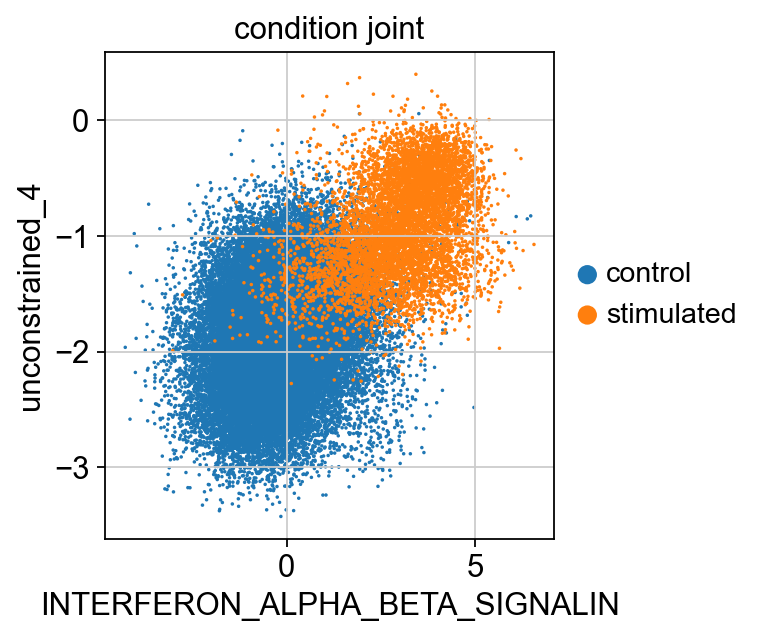

In [58]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='unconstrained_4', color='condition_joint', size=10)

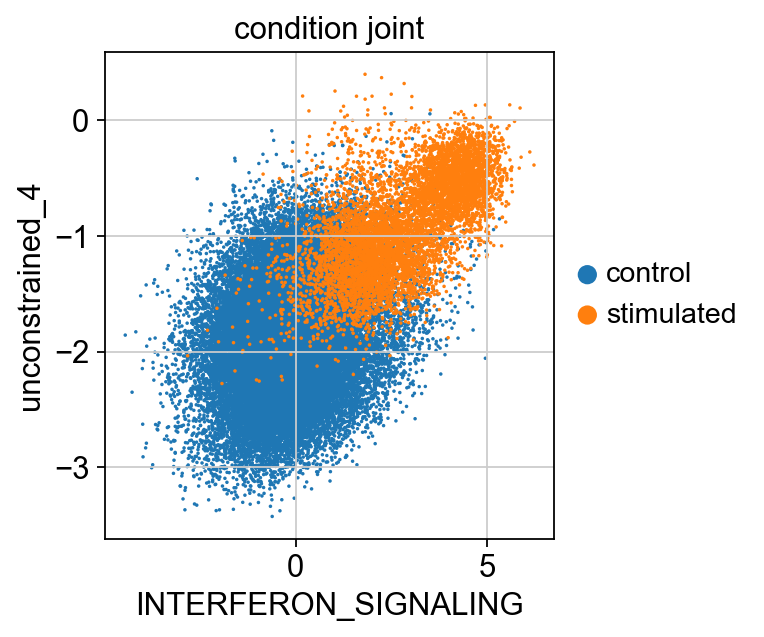

In [59]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_SIGNALING', y='unconstrained_4', color='condition_joint', size=10)

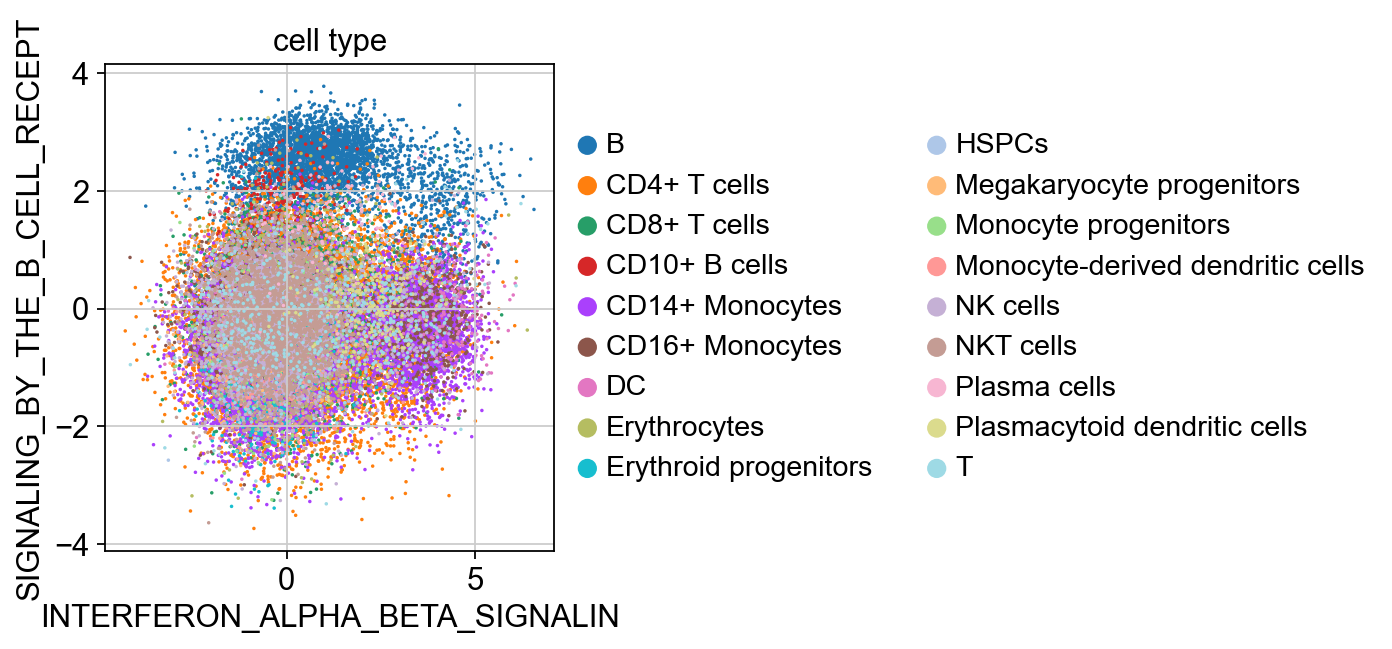

In [60]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='cell_type', size=10)

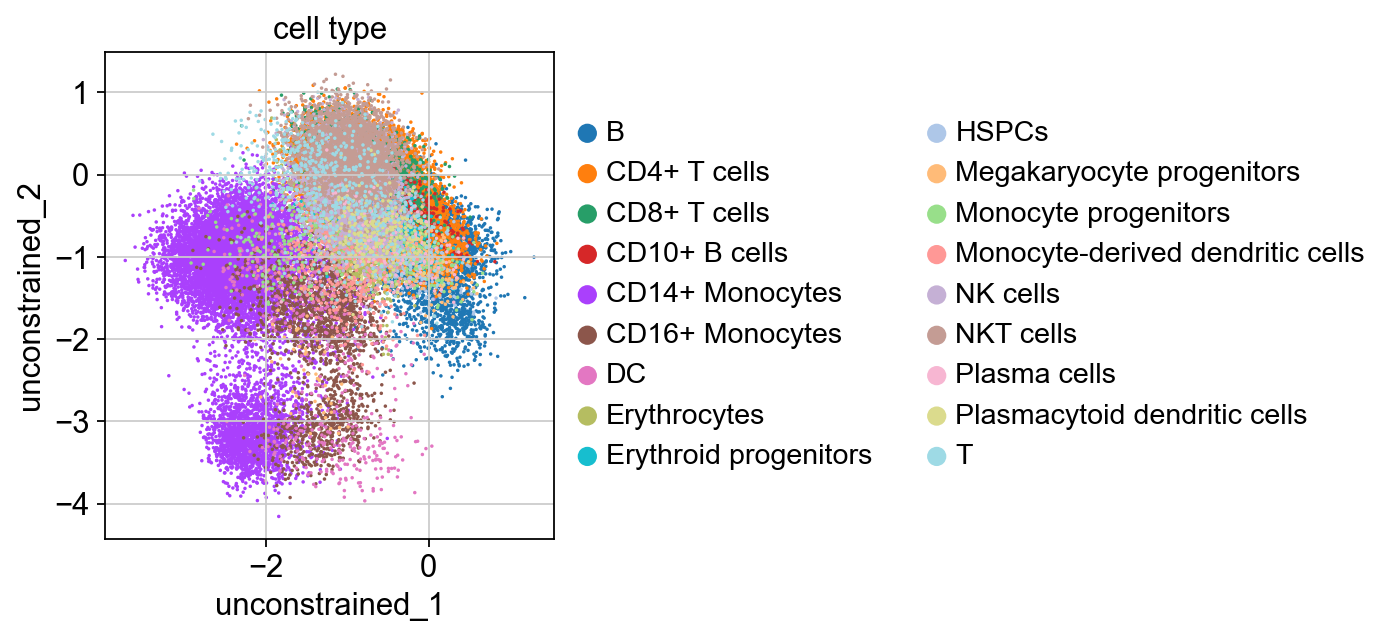

In [65]:
sc.pl.scatter(kang_pbmc, x='unconstrained_1', y='unconstrained_2', color='cell_type', size=10)

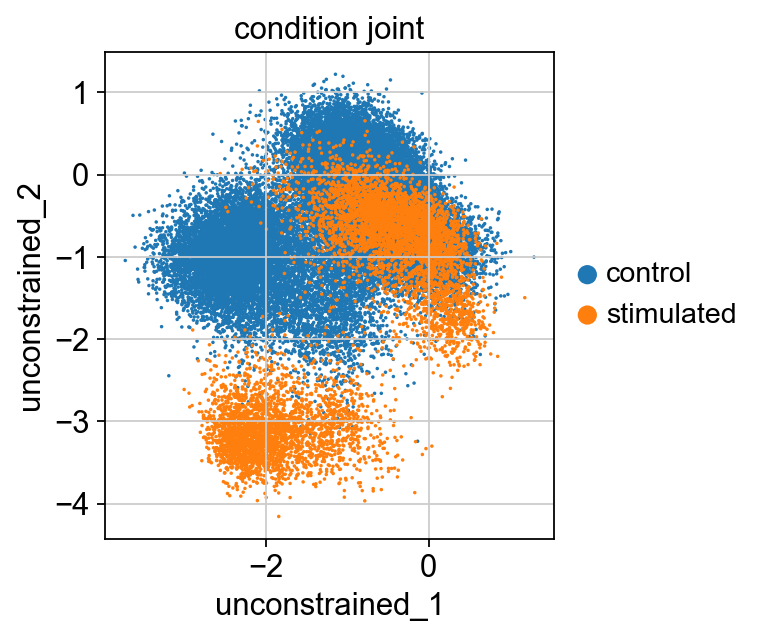

In [62]:
sc.pl.scatter(kang_pbmc, x='unconstrained_1', y='unconstrained_2', color='condition_joint', size=10)

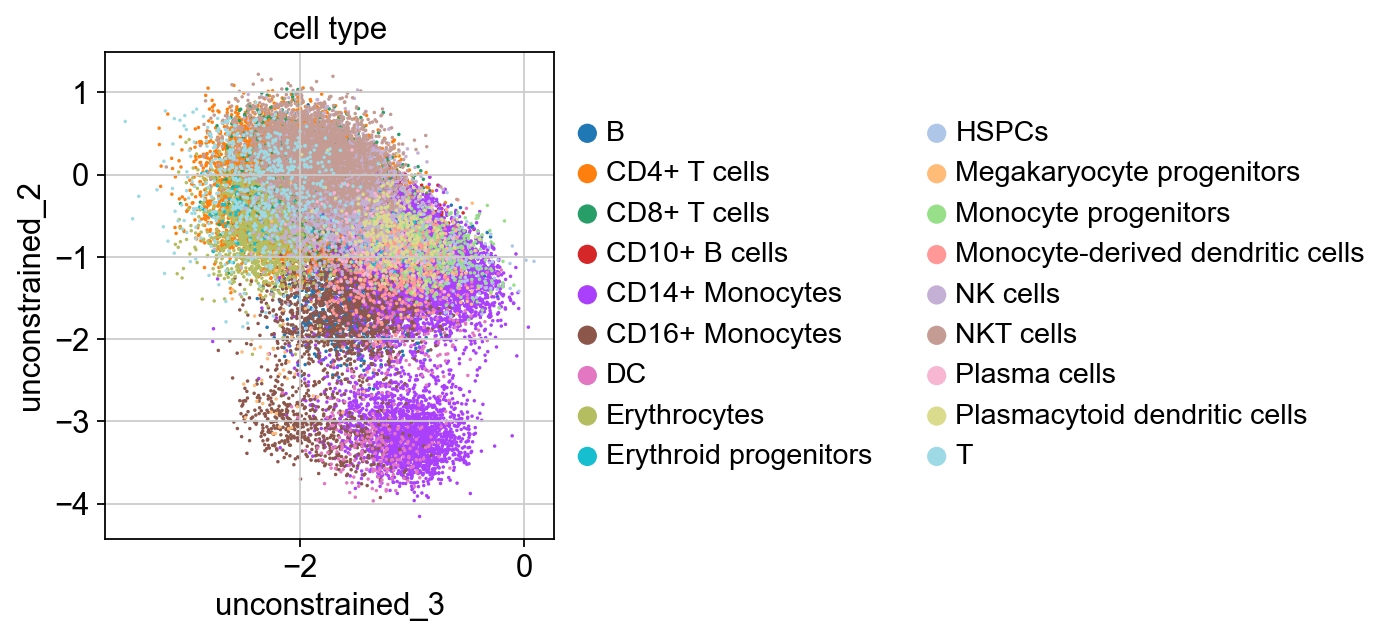

In [71]:
sc.pl.scatter(kang_pbmc, x='unconstrained_3', y='unconstrained_2', color='cell_type', size=10)